# Extraction of the dataset 

Goal: create code to log onto the airdata website and extract information to be stored onto a database. 

In [7]:
import selenium 

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import json, os
import pandas as pd

from datetime import datetime
import time
from bs4 import BeautifulSoup

In [2]:
import airdata_login

In the above file, there are functions to automate the login onto the AirData Website (and to save cookies from a session). 

In [3]:
# extract params
login_URL = airdata_login.login_page_URL
driver = airdata_login.driver 

In [4]:
# set login info
# don't have to repeat this if already logged in once 
cookies_filename = 'login_11_2_2023_cookies.json'
airdata_login.new_login_to_airdata(driver,login_URL,savecookies=True,cookies_filename=cookies_filename, login_details= ('pietro.cicuta@gmail.com','cicutadrone1'))

Cookies successfully saved.


In [5]:
# testing load_cookies 
cookies_filename = 'login_11_2_2023_cookies.json'
driver.get(login_URL)
airdata_login.load_cookies(driver, cookies_filename,login_URL)

now navigate to the flight log page

In [7]:
flight_log_URL = 'https://app.airdata.com/flight/last'
driver.get(flight_log_URL)


/var/folders/tr/p_vqjwh57b3b1hc5glt23nnw0000gp/T/ipykernel_35459/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
# create an empty dataframe to store our results
flight_data_df = pd.DataFrame(columns=['Page URL', 'CSV Filename', 'CSV Download Link']).set_index(pd.Index([], name='Time'))

flight_data_df

,Page URL,CSV Filename,CSV Download Link
Time,,,


The structure of the `flight_log_URL` page: 
![Screenshot 2024-02-12 at 20.49.17.png](<attachment:Screenshot 2024-02-12 at 20.49.17.png>)

Within each flight log page is a CSV file containing all of the information needed about each flight, including whether or not a video was being recorded. 

The element we are concerned for now is the navigation table on the left of the screen. The top buttons can be iterated over by clicking on them and getting the relevent URLS. We'll start by defining a function that navigates through the sidebar pages and returns a list of the flight page elements. Note that they are paginate DataTables.

Put in my rough working below:
- Inspecting the page number buttons 
```
<a class="paginate_button current" aria-controls="item_list_dt" data-dt-idx="1" tabindex="0">1</a>
<a class="paginate_button " aria-controls="item_list_dt" data-dt-idx="2" tabindex="0">2</a>
<a class="paginate_button " aria-controls="item_list_dt" data-dt-idx="3" tabindex="0">3</a>
```

The next page button number has HTML:
```
<a class="paginate_button next" aria-controls="item_list_dt" data-dt-idx="4" tabindex="0" id="item_list_dt_next"><img src="/images/right-16.png"></a>
```

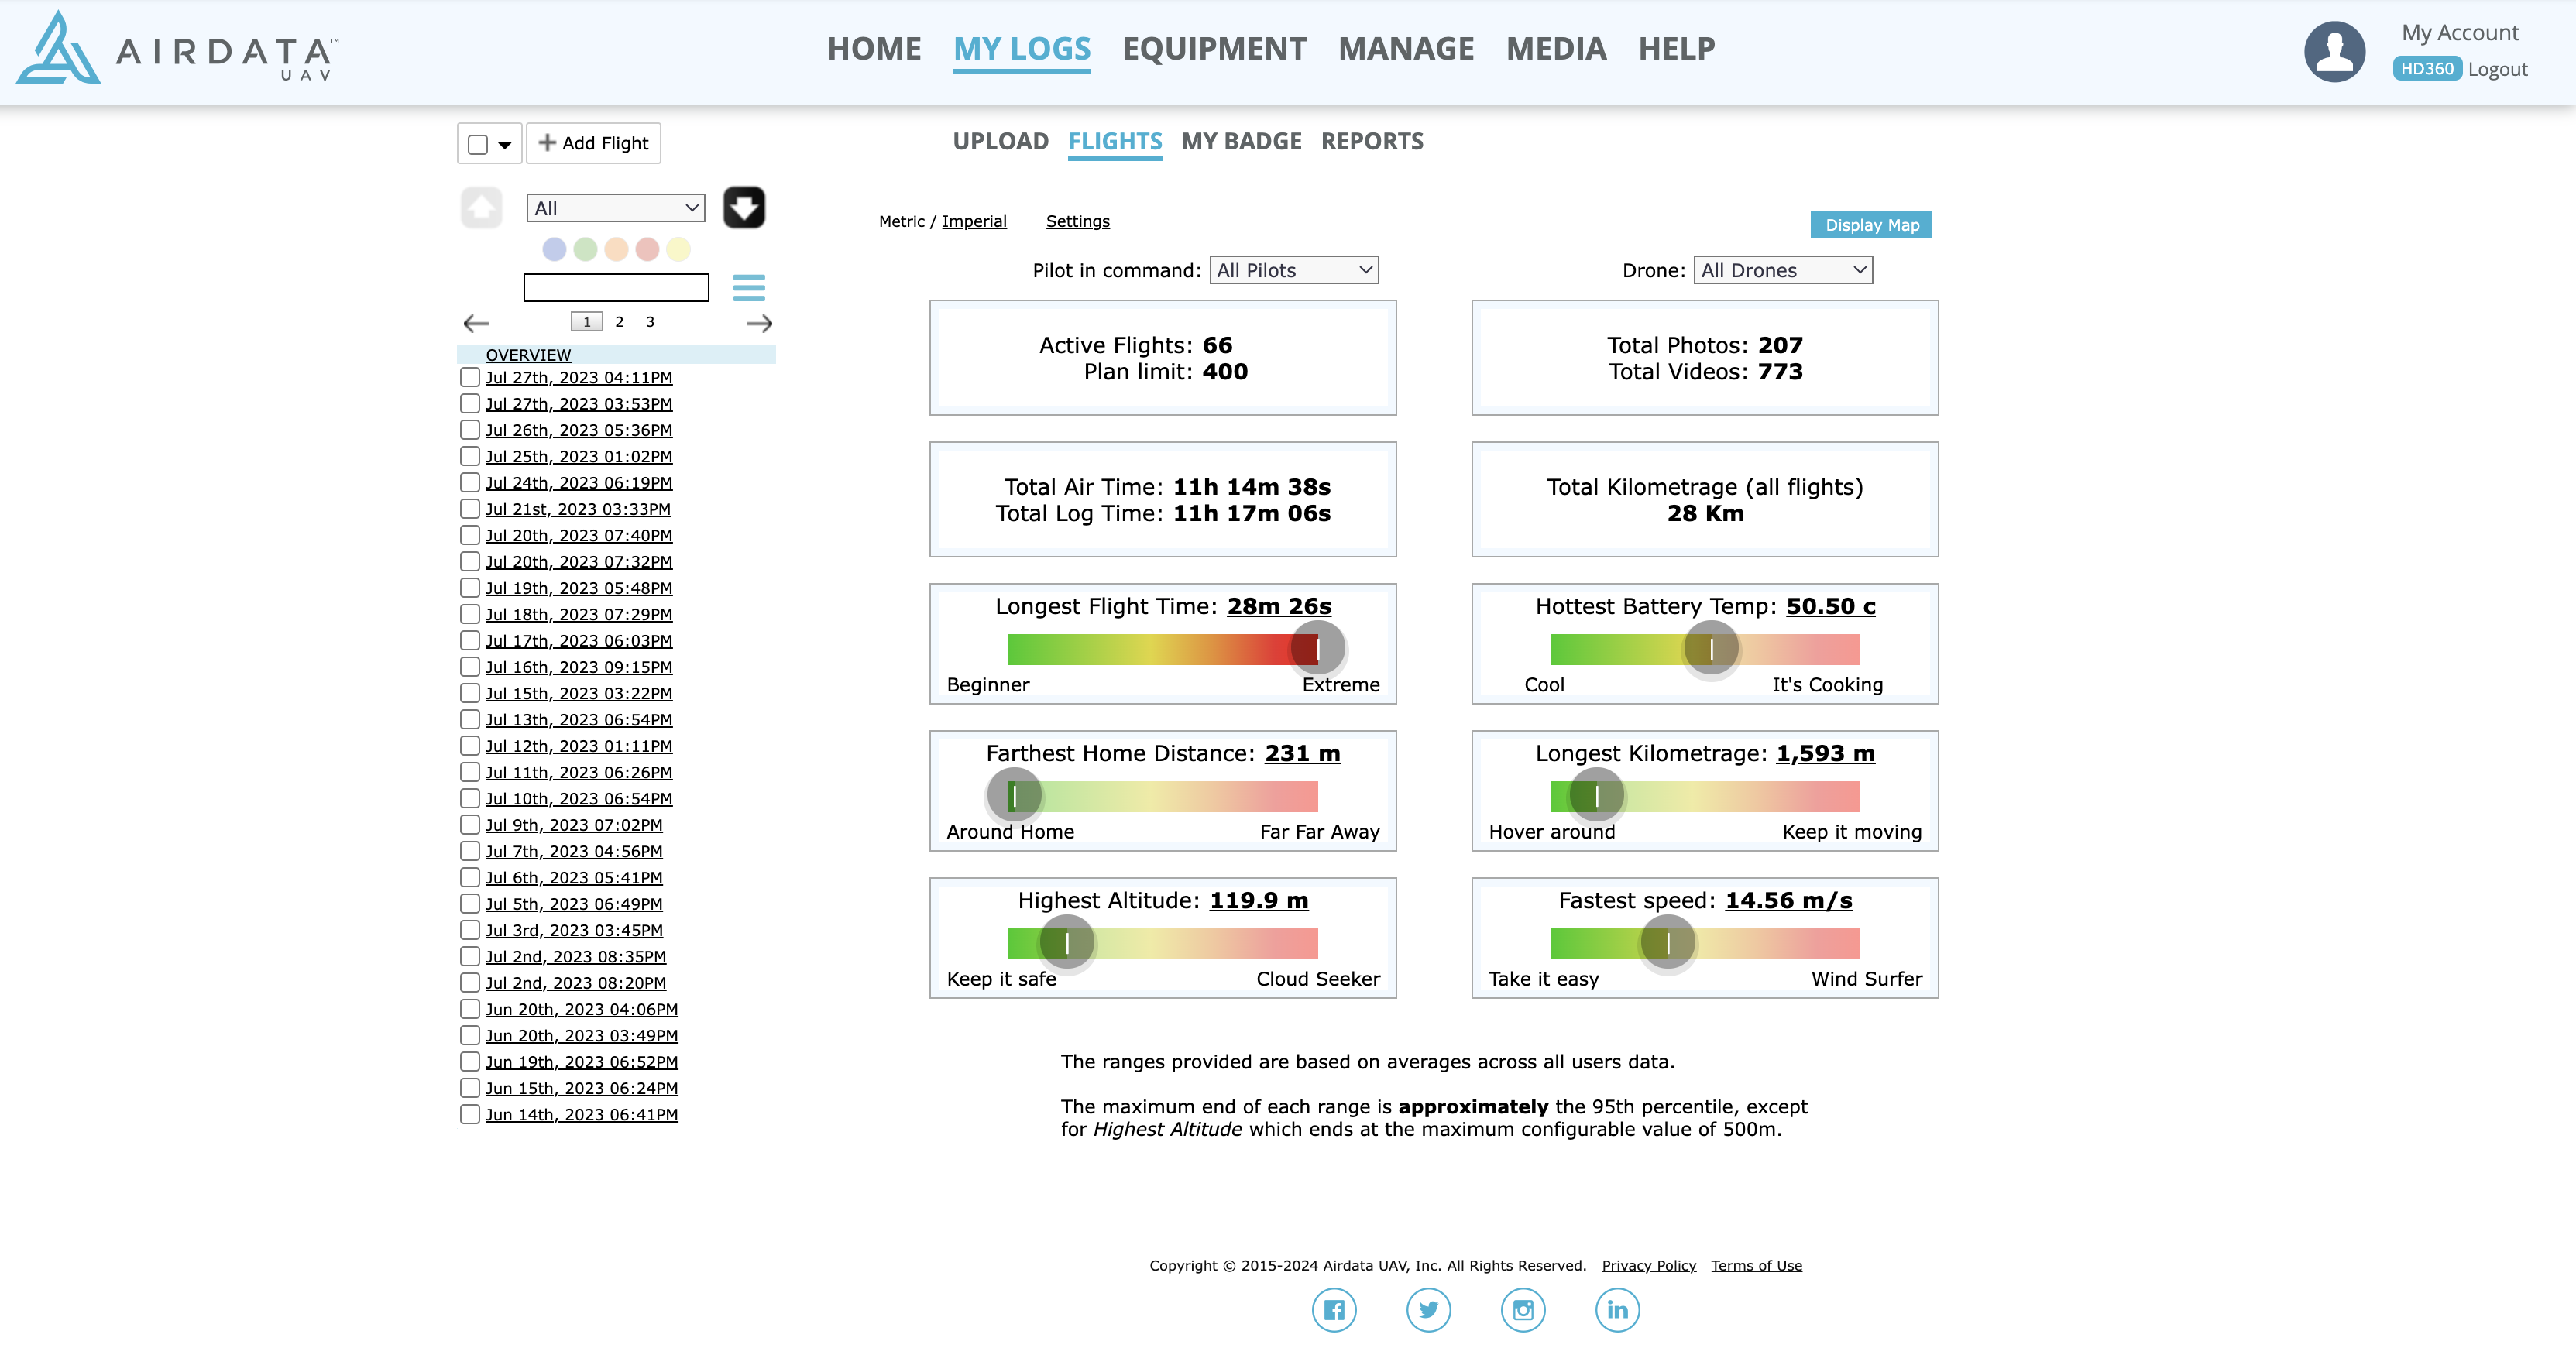

In [8]:
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException
def next_flightlog_page(driver, retries=3):
    """
    Attempts to click the "next" button to navigate to the next page of flight logs.
    Args:
    - driver: The Selenium WebDriver instance.
    - retries: The number of retries if a StaleElementReferenceException is encountered.
    """
    for attempt in range(retries):
        try:
            # Wait for the next button to be clickable at the start of each attempt
            wait = WebDriverWait(driver, 10)
            next_button = wait.until(EC.element_to_be_clickable((By.ID, 'item_list_dt_next')))
            next_button.click()
            return  # Click succeeded, exit the function
        except StaleElementReferenceException:
            if attempt == retries - 1:
                # If this was the last attempt, raise the exception
                raise
            # If not the last attempt, implicitly retry by continuing the loop
        except TimeoutException:
            # If the button doesn't become clickable, raise the exception
            raise TimeoutException("Timeout while waiting for the next page button to be clickable.")


def previous_flightlog_page(driver, retry_count=0):
    wait = WebDriverWait(driver, timeout=10)
    try:
        # Wait for the previous button to be clickable and then click it directly
        prev_button = wait.until(EC.element_to_be_clickable((By.ID, 'item_list_dt_previous')))
        prev_button.click()
    except TimeoutException:
        if retry_count < 3:  # Limit the number of retries to avoid infinite recursion
            previous_flightlog_page(driver, retry_count + 1)
    except StaleElementReferenceException:
        if retry_count < 3:
            previous_flightlog_page(driver, retry_count + 1)

Testing...

In [9]:
next_flightlog_page(driver)

In [10]:
next_flightlog_page(driver)

In [11]:
next_flightlog_page(driver)

Note that if the final page is reached, the flight log page just reloads e.g. no error. 

Also defined a function for going to the previous flight log page

In [12]:
#check that we've returned to the original page 
if driver.current_url == flight_log_URL:
    print('back to original URL')

back to original URL


Goal is now to inspect the table such that we can extract the URLs and dates of the flight logs. We inspect the table and note that for one particular row, the HTML is:
![Screenshot 2024-02-13 at 14.21.24.png](<attachment:Screenshot 2024-02-13 at 14.21.24.png>)


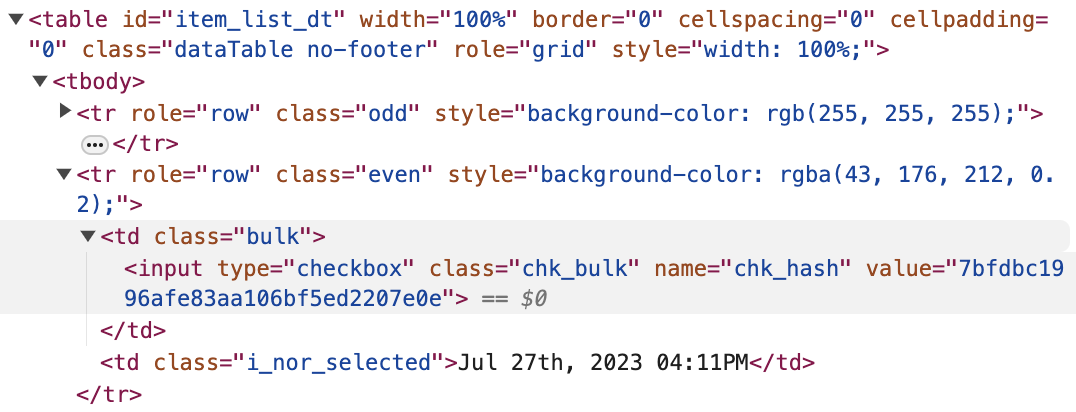

e.g. each row element has two children 
- the checkox child has a chk_hash value that is used to construct the flight log page URL: 'app.airdata.com/flight/'+chk_hash value 
- the text for the other element gives the date and is clickale. Clicking loads the flight log page.

In [13]:
html_content = driver.page_source

In [14]:
soup = BeautifulSoup(html_content,'html.parser')
rows = soup.select('#item_list_dt tbody tr')
rows[0]

<tr class="odd" role="row"><td class="bulk"><input class="chk_bulk" name="chk_hash" type="checkbox" value="ee543e10827a91166a9ed5c8b2ff2e56"/></td><td class="i_nor">May 16th, 2023 07:56PM</td></tr>

In [15]:
# testing the selection
rows[0].select('tr>td')[0]
row_chk, row_name_button = rows[0].select('tr>td')
row_name_button.text.strip()

'May 16th, 2023 07:56PM'

In [16]:
# testing the selection
row_chk, row_name_button = rows[1].select('tr>td')

row_chk.find()['value']

'95f07c9c2abebfda33318d1cdf3ec4d0'

In [17]:
row_name_button.text.strip()

'Jul 20th, 2022 05:00PM'

In [18]:
# example of converting row name strings into datetime objects 
from datetime import datetime
date_str = row_name_button.text.strip()
formatted_str = date_str.replace('th', '').replace('rd', '').replace('nd', '').replace('st', '')
dt_obj = datetime.strptime(formatted_str, '%b %d, %Y %I:%M%p')
dt_obj

datetime.datetime(2022, 7, 20, 17, 0)

In [19]:
date_str

'Jul 20th, 2022 05:00PM'

This will be useful since the csv file to be downloaded associated with each flight has name in the form 'Jul-27th-2023-03-53PM-Flight-Airdata.csv' , for example. Constructing CSV filename using the dt object:

In [20]:
def get_datetime_object_from_name(date_str):
    '''
    Given a string formatted in the form 'Jul 27th, 2023, 04:11PM' return a datetime object
    '''
    formatted_str = date_str.replace('th', '').replace('rd', '').replace('nd', '').replace('st', '')
    dt_obj = datetime.strptime(formatted_str, '%b %d, %Y %I:%M%p')
    return dt_obj

def generate_csv_filename_from_date(date_obj):
    """
    Given a datetime object
    returns the corresponding CSV filename following the format
    'MMM-dd-YYYY-hh-mmPM/AM-Flight-Airdata.csv', after removing day suffixes.
    """
    def day_suffix(day):
        if 11 <= day <= 13:
            return 'th'
        else:
            return {1: 'st', 2: 'nd', 3: 'rd'}.get(day % 10, 'th')
    
    formatted_date_str = date_obj.strftime(f'%b-%d{day_suffix(date_obj.day)}-%Y-%I-%M%p')
    
    # Replace the day part to include the correct suffix
    filename = f"{formatted_date_str}-Flight-Airdata.csv"
    
    return filename

# Example usage
print(generate_csv_filename_from_date(dt_obj))


Jul-20th-2022-05-00PM-Flight-Airdata.csv


In [21]:
def get_page_item_info():
    data = {'Time': [], 'Flight URL': [], 'CSV filename': []} # initialise a dictionary to store the pagedata
    wait = WebDriverWait(driver,timeout=10)
    try:
        load_completed = wait.until(EC.presence_of_all_elements_located((By.ID,'item_list_dt_previous')))
        if load_completed:
            html_content = driver.page_source
            # parse the HTML of the page
            soup = BeautifulSoup(html_content,'html.parser')
            # now use beautiful soup methods to find the rows 
            rows = soup.select('#item_list_dt tbody tr')
            for row in rows:
                row_chk, row_name_button = row.find_all('td')
                if row_name_button.text.strip() != 'OVERVIEW': #skip the overview row 
                    # extract the flight date and time 
                    flight_dt_text = row_name_button.text.strip() 
                    flight_dt_obj = get_datetime_object_from_name(flight_dt_text)
                    
                    # construct the CSV filename
                    flight_CSV_filename = generate_csv_filename_from_date(flight_dt_obj)
                    
                    # construct the flight URL from the chk_hash value
                    row_chk_hash = row_chk.find('input')['value']
                    flight_page_URL = f'https://app.airdata.com/flight/{row_chk_hash}'
                    
                    # Append data to the dictionary
                    data['Time'].append(flight_dt_obj)
                    data['Flight URL'].append(flight_page_URL)
                    data['CSV filename'].append(flight_CSV_filename)
                    
    except TimeoutException:
        get_page_item_info()
    return data 

In [22]:
driver.get(flight_log_URL)
get_page_item_info()

{'Time': [datetime.datetime(2023, 7, 27, 16, 11),
  datetime.datetime(2023, 7, 27, 15, 53),
  datetime.datetime(2023, 7, 26, 17, 36),
  datetime.datetime(2023, 7, 25, 13, 2),
  datetime.datetime(2023, 7, 24, 18, 19),
  datetime.datetime(2023, 7, 21, 15, 33),
  datetime.datetime(2023, 7, 20, 19, 40),
  datetime.datetime(2023, 7, 20, 19, 32),
  datetime.datetime(2023, 7, 19, 17, 48),
  datetime.datetime(2023, 7, 18, 19, 29),
  datetime.datetime(2023, 7, 17, 18, 3),
  datetime.datetime(2023, 7, 16, 21, 15),
  datetime.datetime(2023, 7, 15, 15, 22),
  datetime.datetime(2023, 7, 13, 18, 54),
  datetime.datetime(2023, 7, 12, 13, 11),
  datetime.datetime(2023, 7, 11, 18, 26),
  datetime.datetime(2023, 7, 10, 18, 54),
  datetime.datetime(2023, 7, 9, 19, 2),
  datetime.datetime(2023, 7, 7, 16, 56),
  datetime.datetime(2023, 7, 6, 17, 41),
  datetime.datetime(2023, 7, 5, 18, 49),
  datetime.datetime(2023, 7, 3, 15, 45),
  datetime.datetime(2023, 7, 2, 20, 35),
  datetime.datetime(2023, 7, 2, 20,

In [23]:
def combine_flight_data():
    '''
    iterates through all the flight log sidebar pages
    stores the resulting data in a dataframe
    '''
    global driver
    driver.get(flight_log_URL)
    result_dict = {'Time': [], 'Flight URL': [], 'CSV filename': []}
    for i in range(3):
        page_info = get_page_item_info()
        result_dict['Time'].extend(page_info['Time'])
        result_dict['Flight URL'].extend(page_info['Flight URL'])
        result_dict['CSV filename'].extend(page_info['CSV filename'])
        next_flightlog_page(driver)
    result_df = pd.DataFrame(result_dict)
    result_df['Time'] = pd.to_datetime(result_df['Time'])
    result_df.set_index('Time',inplace=True)
    return result_df

In [24]:
flight_pages_df = combine_flight_data()

In [25]:
# save as CSV
combine_flight_data().to_csv('flight_pages_info.csv',index = True)

We see that we have the correct number of rows, e.g. all the flights have been logged here. Now the next step is iterate through the flight pages and download the correct CSV files. 

In [26]:
# example
idx = flight_pages_df.index[2]
ex_URL = flight_pages_df.loc[idx,'Flight URL']

In [31]:
driver.get(ex_URL)
wait = WebDriverWait(driver,10)
csv_link = wait.until(EC.element_to_be_clickable((By.ID, "csv_link")))

# Click the download link
csv_link.click()

The below code automates the download of the csv file including methods to handle being automatically logged out. It's not *that* efficient and ends up in some repeat downloads which you can manually get rid of but takes about 5 minutes to complete. 

Once extraction of the CSV files is complete focus is on cleaning the data. 

In [40]:
from selenium.common.exceptions import UnexpectedAlertPresentException, TimeoutException, NoAlertPresentException

def download_csv_from_flight_page(driver, flight_page_urls):
    """
    Navigates to each flight page URL and clicks the download link for the CSV file.
    Args:
    - driver: The Selenium WebDriver instance.
    - flight_page_urls: A list of URLs to flight pages.
    """
    
    for url in flight_page_urls:
        try:
            driver.get(url)
            
            
            # Wait for the download link to be clickable
            wait = WebDriverWait(driver, 10)
            csv_link = wait.until(EC.element_to_be_clickable((By.ID, "csv_link")))
            
            # Click the download link
            csv_link.click()
            wait.until(lambda driver: driver.find_element(By.ID, "csv_link").text.lower() == 'wait')
            wait.until(lambda driver: driver.find_element(By.ID, "csv_link").text.lower() != 'wait')
            time.sleep(5)
            print('downloaded')
            try: 
                alert = driver.switch_to.alert
                print(f"Alert detected: {alert.text}")
                
                airdata_login.new_login_to_airdata(driver,login_URL,savecookies=True,cookies_filename=cookies_filename, login_details= ('pietro.cicuta@gmail.com','cicutadrone1'))
            except NoAlertPresentException:
                print('no alert')
            # Navigate to the flight page URL

        except UnexpectedAlertPresentException as e:
            print(f"Handling unexpected alert: {e.alert_text}")
            airdata_login.new_login_to_airdata(driver,login_URL,savecookies=True,cookies_filename=cookies_filename, login_details= ('pietro.cicuta@gmail.com','cicutadrone1'))
            driver.get(url)
        
            
            # Wait for the download link to be clickable
            wait = WebDriverWait(driver, 10)
            csv_link = wait.until(EC.element_to_be_clickable((By.ID, "csv_link")))
            
            # Click the download link
            csv_link.click()
            print('downloaded')
        # Add a delay to ensure the file download starts, adjust as needed
        
flight_page_URLS = flight_pages_df['Flight URL']
download_csv_from_flight_page(driver,flight_pages_df['Flight URL'])

downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert
downloaded
no alert


In [42]:
len(flight_pages_df['Flight URL'])

66

In [45]:
import os 
len([entry for entry in os.listdir('/Users/ayahusseini/Project/Database/original_flight_CSV_files')])

67

## getting weather information 

In [8]:
pd.read_csv('flight_pages_info.csv')

,Time,Flight URL,CSV filename
0,2023-07-27 16:11:00,https://app.airdata.com/flight/7bfdbc1996afe83...,Jul-27th-2023-04-11PM-Flight-Airdata.csv
1,2023-07-27 15:53:00,https://app.airdata.com/flight/41033bf8641d822...,Jul-27th-2023-03-53PM-Flight-Airdata.csv
2,2023-07-26 17:36:00,https://app.airdata.com/flight/43cdc627ccde14a...,Jul-26th-2023-05-36PM-Flight-Airdata.csv
3,2023-07-25 13:02:00,https://app.airdata.com/flight/05c7e9d257d58fc...,Jul-25th-2023-01-02PM-Flight-Airdata.csv
4,2023-07-24 18:19:00,https://app.airdata.com/flight/c857502e378f2f0...,Jul-24th-2023-06-19PM-Flight-Airdata.csv
...,...,...,...
61,2022-07-09 14:11:00,https://app.airdata.com/flight/133e42239124c73...,Jul-09th-2022-02-11PM-Flight-Airdata.csv
62,2022-07-09 13:59:00,https://app.airdata.com/flight/aaf1a159b480629...,Jul-09th-2022-01-59PM-Flight-Airdata.csv
63,2022-07-09 13:48:00,https://app.airdata.com/flight/de9cdd88f664cd8...,Jul-09th-2022-01-48PM-Flight-Airdata.csv
64,2022-07-09 12:21:00,https://app.airdata.com/flight/0bc16291adb756d...,Jul-09th-2022-12-21PM-Flight-Airdata.csv


In [11]:
example_weather_url = 'https://app.airdata.com/flight/95f07c9c2abebfda33318d1cdf3ec4d0/WEATHERWind_Map'
driver.get('https://app.airdata.com/flight/95f07c9c2abebfda33318d1cdf3ec4d0/WEATHERWind_Map')
WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, "infoboxlabel"))
)
html_content = driver.page_source
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table', {'class': 'infoboxlabel'})

data = []
for row in table.find_all('tr')[1:]:  # Skipping the header row
    cols = row.find_all('td')
    data_row = {
        "Flight Time": cols[1].text.strip(),
        "Altitude": cols[2].text.strip(),
        "Home Distance": cols[3].text.strip(),
        "Wind Direction": cols[4].text.strip(),
        "Wind Speed": cols[6].text.strip()
    }
    data.append(data_row)

df = pd.DataFrame(data)
df.head()

,Flight Time,Altitude,Home Distance,Wind Direction,Wind Speed
0,00m 15s,3.9 m,0 m,255°,2.88 m/s
1,00m 20s,3.9 m,0 m,257°,3.54 m/s
2,00m 40s,4.1 m,11 m,256°,3.72 m/s
3,00m 45s,4.1 m,11 m,263°,3.34 m/s
4,00m 50s,4.1 m,11 m,266°,2.78 m/s


In [12]:
df.to_pickle('Jul_20_2022_weather_information')